In [7]:
import numpy as np
import matplotlib.pyplot as plt

### 1. Entanglement entropy

One approach to studying quantum correlations in spin chains is calculating the bipartite entropy of entanglement between a subsystem $A$ of $L$ contiguous particles and the rest of the system, when it is in a pure state $\rho$:

$$
S = s[\rho_A]
$$

$$
\begin{aligned}
\rho_A &= \mathrm{tr}_{\bar A} \rho, & \bar{A} &= \{0, ..., N-1\}\backslash A
\end{aligned}
$$

for an appropriate entropy functional $s$. Since the state is pure we may take it to be $|M\rangle=\prod\limits_{n=0}^{M-1}\tilde{a}^\dagger_n|0\rangle$. We can then calculate the $L\times L$ correlation matrix $C(L, M)\equiv C$

$$
\begin{aligned}
C_{nm} &= \langle M|a^\dagger_n a_m|M\rangle, & n,m = 0, ..., L-1
\end{aligned}
$$

It is easy to check that

$$
\begin{aligned}
\langle M|\tilde{a}^\dagger_n\tilde{a}_m|M\rangle &= \delta_{nm}\chi_M, & \chi_M &=
    \begin{cases}
    1, \quad n\in\{0, ..., M-1\} \\
    0, \quad n\not\in\{0, ..., M-1\}
    \end{cases}
\end{aligned}
$$

And then since $a_n = \sum\limits_{k=0}^{N-1} \Phi_{nk}\tilde{a}_k$

$$
C_{nm} = \sum\limits_{j=0}^{N-1}\sum\limits_{k=0}^{N-1}\Phi_{nj}\Phi_{mk}\delta_{jk}\chi_M=
\sum\limits_{k=0}^{M-1}\Phi_{nk}\Phi_{mk}=
\sum\limits_{k=0}^{M-1}\frac{w_k}{\sqrt{\gamma_n \gamma_m}} P_n(\varepsilon_k)P_m(\varepsilon_k)
$$

In [22]:
# Calculating correlation matrix
def OPS(N, a, b):
    P = np.zeros((N+1, N+1))
    P[0, N] = 1
    P[1, -2:] = [1, - b[0]]
    for n in range(1, N):
        P[n+1] = np.roll(P[n], -1) - b[n] * P[n] - a[n-1] * P[n-1]
    return P

def corr(N, J, h, L, M):
    P = OPS(N, J**2, h)
    E = np.sort(np.roots(P[N]))[:M]
    gamma = np.cumprod(J)**2
    gamma = np.append(1, gamma)
    denominator = np.polyval(P[N-1], E) * np.polyval(np.polyder(P[N]), E)
    w = np.prod(J)**2 / denominator
    C = np.empty((L, L))
    for n in range(L):
        C[n] = [np.sum(w*np.polyval(P[n], E)*np.polyval(P[m], E))/np.sqrt(gamma[n]*gamma[m]) for m in range(L)]
    return C

# Example / test
N = 5
J = np.linspace(1, N-1, N-1)
h = np.ones(N)
L, M = 3, 3
C = corr(N, J, h, L, M)
print('Correlation matrix from orthogonal polynomial system: ')
print(np.around(C, 3))

H1 = np.diag(h) + np.diag(J, 1) + np.diag(J, -1)
Phi = np.linalg.eigh(H1)[1][:L, :M]
print('Correlation matrix from diagonalisation: ')
print(np.around(Phi @ Phi.T, 3))

Correlation matrix from orthogonal polynomial system: 
[[ 0.86  -0.261 -0.18 ]
 [-0.261  0.5   -0.386]
 [-0.18  -0.386  0.59 ]]
Correlation matrix from diagonalisation: 
[[ 0.86  -0.261 -0.18 ]
 [-0.261  0.5   -0.386]
 [-0.18  -0.386  0.59 ]]


Refs. [2], [3] study Rényi entropy $s_\alpha$:

$$
\begin{aligned}
s_\alpha[\rho_A] &= \frac{1}{1-\alpha}\log\mathrm{tr}(\rho^\alpha_A), & \alpha>0
\end{aligned}
$$

$$
s[\rho_A]\equiv\lim\limits_{\alpha\rightarrow1}s_\alpha[\rho_A]=-\mathrm{tr}(\rho_A\log\rho_A)
$$

Once we have computed the correlation matrix, we can use it's eigenvalues $\nu_i$ to compute entropy via the formula

$$
S = \sum\limits_{i=0}^{L-1}s^{(2)}(\nu_i)
$$

where $s^{(2)}\equiv s[\mathrm{diag}(x, 1-x)]$ is the binary entropy

$$
s_\alpha^{(2)}(x) = \frac{1}{1-\alpha}\log(x^\alpha+(1-x)^\alpha)
$$

$$
s^{(2)}(x) = -x\log x-(1-x)\log(1-x)
$$

Since $C = \Phi_{LM}\Phi_{LM}^\mathrm{T}$ is real, symmetric, positive definite, and so is $I-C$, then $0\leq\nu_i\leq1$, as expected for probabilities.

In [23]:
def bin_entropy(alpha, nu):
    if alpha == 1:
        return - nu * np.log(nu) - (1 - nu) * np.log(1 - nu)
    return np.log(nu ** alpha + (1 - nu) ** alpha) / (1 - alpha)

# Example / test
N = 5
J = np.linspace(1, N-1, N-1)
h = np.ones(N)
L, M = 3, 3
alpha = 1

C = corr(N, J, h, L, M)
nu = np.linalg.eigvalsh(C)
S = np.sum(bin_entropy(alpha, nu))
print(f'Entanglement entropy: {S}')

Entanglement entropy: 0.4509754963522565


### 2. Homogeneous XX chain

The homogeneous chain studied in [1] has $J_n=J\in\mathbb{R}$, $h_n=h\in\mathbb{R}$. If we considered periodic boundary conditions, the system would be invariant under translations (all sites on the chain look the same). Translational invariance would imply momentum conservation, therefore we should work in the momentum (Fourier) basis.

$$
\tilde{a}_k = \frac{1}{\sqrt{N}}\sum\limits_{n=0}^{N-1} a_n e^{-i\frac{2\pi}{N}nk}
$$

So $E=\Phi^\dagger H^1\Phi$, with the diagonalisation being $\Phi_{nk}=\frac{1}{\sqrt{N}}e^{-i\frac{2\pi}{N}nk}$. Let's naively apply this diagonalisation to the $H^1$ matrix with free boundary conditions:

$$
\sum\limits_{n=0}^{N-1}\sum\limits_{m=0}^{N-1}\Phi^\dagger_{jn} H^1_{nm} \Phi_{mk} = 
\frac{1}{N}\sum\limits_{n=0}^{N-1}\sum\limits_{m=0}^{N-1}e^{i\frac{2\pi}{N}jn}e^{-i\frac{2\pi}{N}mk}(J\delta_{n+1,m}+J\delta_{n-1,m}+h\delta_{nm}) =
$$

$$
= \frac{1}{N}\left(
(e^{i\frac{2\pi}{N}k}+e^{-i\frac{2\pi}{N}k})J\sum\limits_{n=0}^{N-2}e^{i\frac{2\pi}{N}n(j-k)}+
h\sum\limits_{n=0}^{N-1}e^{i\frac{2\pi}{N}n(j-k)}
\right) =
$$

$$
= \left(2\cos\left(\frac{2\pi k}{N}\right)J+h\right)\delta_{jk}+ o\left(\frac{1}{N}\right)
$$

$$
\boxed{
\begin{aligned}
    H&\approx\sum\limits_{n=0}^{N-1}\varepsilon_n\tilde{a}^\dagger_n\tilde{a}_n, &
    \varepsilon_n&\approx2\cos\left(\frac{2\pi n}{N}\right)J+h
\end{aligned}
}
$$

The diagonalisation still works in the thermodynamic limit, when $N\rightarrow\infty$.

Text(0, 0.5, 'max |off diagonal|')

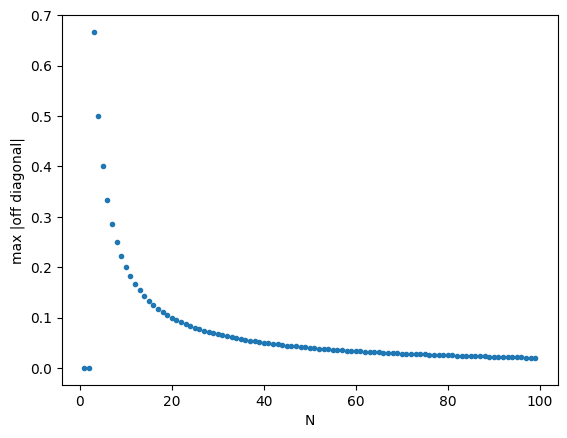

In [ ]:
# Numerical test
@np.vectorize()
def offdiag_max(N, J, h):
    H1 = h * np.diag(np.ones(N)) + J * (np.diag(np.ones(N-1), k=1) + np.diag(np.ones(N-1), k=-1))
    FT = np.fft.fft(np.eye(N), norm='ortho') # Fourier transform matrix
    E = np.conj(FT) @ H1 @ FT 
    return np.max(np.abs(E-np.diag(np.diag(E))))

Nmax = 100
J = 1
h = 2

N = np.arange(1, Nmax)
o = offdiag_max(N, J, h)
plt.plot(N, o, '.')
plt.xlabel('N')
plt.ylabel(r'max |off diagonal|')

We can now easily find the ground state. It will have one particle at each site that $\varepsilon_n$ is negative, therefore there are only particles where

$$
- \left(\frac{h}{J}\right) > 2\cos\left(\frac{2\pi n}{N}\right)
$$

Or, in other words

$$
\begin{aligned}
n_c \leq n \leq N - n_c, & & n_c &= \left\lceil\frac{N}{2\pi}\arccos\left(\frac{-h}{2J} \right)\right\rceil
\end{aligned}
$$

We then realise that if $h/J>2$ (the magnetic field is strong), the ground state is the vacuum $|0\rangle$ (all spins up). In the limit $h/J\rightarrow0$ however, $\sum_n\varepsilon_n=0$, therefore the ground state could be $|0\rangle$ (all spins up) or $\prod_n a^\dagger_n|0\rangle$ (all spins down, $|1\rangle^{\otimes N}$ in the computational basis).

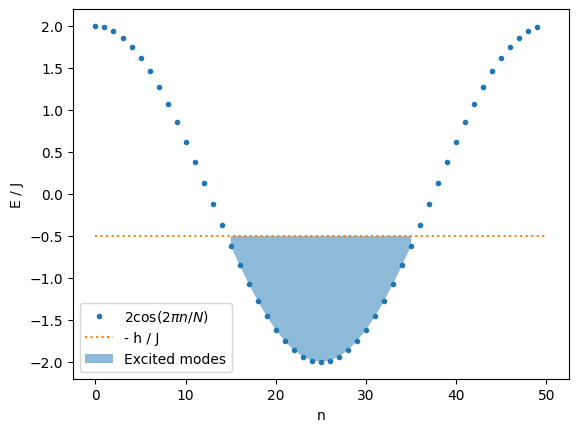

In [ ]:
# Let's visualise this
N = 50
J = 2
h = 1

nc = int(np.ceil(N * np.arccos(- h / (2*J)) / (2 * np.pi)))
n = np.linspace(0, N-1, N)
osc = 2 * np.cos(2 * np.pi * n / N)
plt.plot(n, osc, '.')
plt.plot([0, N], [-h/J, -h/J], ':')
plt.fill_between(n[nc:N-nc+1], osc[nc:N-nc+1], - h / J, alpha=.5)
plt.xlabel('n')
plt.ylabel('E / J')
plt.legend(['$2\cos(2\pi n/N)$', '- h / J', 'Excited modes'])

### 3. General case

According to ref. [3] 

$$
\mathrm{d}s^2 = J(x)^2 \mathrm{d}t^2 - \mathrm{d}x^2
$$

### References

[1] Latorre, J., & Riera, A. (2009). A short review on entanglement in quantum spin systems. *Journal of Physics A: Mathematical and Theoretical, 42(50), 504002*. Retrieved from https://arxiv.org/abs/0906.1499

[2] Finkel, F., & González-López, A. (2020). Inhomogeneous XX spin chains and quasi-exactly solvable models. *Journal of Statistical Mechanics: Theory and Experiment, 2020(9), 093105*. Retrieved from https://arxiv.org/abs/2007.00369

[3] Finkel, F., & González-López, A. (2021). Entanglement entropy of inhomogeneous XX spin chains with algebraic interactions. *Journal of High Energy Physics, 2021(12)*. Retrieved from https://arxiv.org/abs/2107.12200